# Tutorial - Data Wrangling with Pandas and Geopandas

<ins>Topics:</ins>

**1. Pandas**
+ Import spreadsheet / csv data into notebook with pandas
+ Reshape tabular data (slicing, pivoting, resampling)
+ Simple plotting

**2. Geopandas**
+ Accessing shape files
+ Plot data on a map
+ Spatial selection 

<hr>

# Python for Environmental Modellers: Essential Libraries 

This tutorial introduces a number of essential libraries useful for environmental modelling:

**Pandas** is a library to work with tabulated data like Excel files or databases. Shape-files and other spatials data  are handled with the **Geopandas** extension.

**Matplotlib** is the common workhorse for visualization. It provides code-efficient commands to create publishing-ready figures. A number of of libraries (including Pandas or TimML) rely on matplotlib for visualization.

Other popular libraries of interest are:

+ numpy (numerical computation, support for large arrays of data)
+ scipy (scientific computation - integration, linear algebra, optimization, ...)
+ statsmodels (statistics - regression, ...)
+ scikit-learn (machine learning)

**Further Reading**: For who is interested to read more about this topic, we recommend the textbook *Python for Data Analysis* by Wes McKinney (O'Reily, ISBN 978-1-491-95766-0) 

<img src="https://jakevdp.github.io/PythonDataScienceHandbook/figures/PDSH-cover.png" width="250">

<hr>

## 1. PANDAS

### Loading Data

#### Import Data from files

Large datasets are usually imported from files. This example uses an Excel file.

Other input formats common to modelling can be imported in a very similar way:

    df_csv = pd.read_csv()
    df_dat = pd.read_csv(delim_whitespace=True)
    df_sql = pd.read_sql()
    df_pickle = pd.read_pickle()
    
pickle is a binary format for python objects. Useful if working with notebooks that require long processing times (allows to make intermediary saves and to avoid re-running the complete notebook after restarting Jupyter).

In [1]:
import pandas as pd
df = pd.read_excel("./example_data/drawdown_curves.xlsx")
df

,ID,X,Y,Curve
0,1,0.000000,282.355087,well1
1,2,0.001000,282.360041,well1
2,3,0.202599,282.364786,well1
3,4,4.258534,282.367443,well1
4,5,8.960126,282.375180,well1
...,...,...,...,...
4963,4964,3258.268986,298.772300,well4
4964,4965,3261.021002,298.772508,well4
4965,4966,3267.344699,298.767232,well4
4966,4967,3277.942848,298.746713,well4


In [2]:
# dataframe provides some methods e.g. for data exploration:
df.describe()

,ID,X,Y
count,4968.000000,4968.000000,4968.000000
mean,2484.500000,1700.799433,291.581078
std,1434.282399,978.678132,7.063675
min,1.000000,0.000000,277.026027
25%,1242.750000,821.999998,284.790000
50%,2484.500000,1756.432161,291.997790
75%,3726.250000,2586.999991,298.613227
max,4968.000000,3286.999986,304.306332


***

#### Export Data 

In [3]:
# Saving to files works the other way around:
df.to_csv("./example_data/drawdown_curves.csv")

***

#### Converting Stacked tables

The XLSX file contains time series that have been exported from the FEFLOW GUI. 

It has the form of a stacked table, meaning that data of all times and observation points appear in the same table. This is a quite common format in model outputs in general, however not really useful for processing.

Pandas provides an in-built function to tabulate the data with an individual column per observation bore. This is done by using the `pivot`-function

**Note:** this is useful if all observation points share the same time steps (as they usually do in model output). For measurement data with usually asynchrounous data, the data should be resampled (see below) if tabulation is required.

In [4]:
# to tabulate the data, provide the names of the columns that contain the index (here: X, time), the values (here: Y)
# and the columns (here: curve)
df_pivot = df.pivot(index="X", values="Y", columns="Curve")
df_pivot.index.name = "Time"

In [5]:
df_pivot

Curve,well1,well2,well3,well4,well5,well6,well7,well8,well9
Time,,,,,,,,,
0.000000,282.355087,284.927644,287.622602,304.253642,301.389564,300.247835,295.997291,293.399888,290.918312
0.001000,282.360041,284.932594,287.627552,304.258596,301.394516,300.252795,296.002262,293.404844,290.923290
0.202599,282.364786,284.937580,287.632981,304.263494,301.399505,300.256153,296.007872,293.410269,290.928536
4.258534,282.367443,284.943866,287.650610,304.267792,301.400036,300.228460,296.019664,293.424332,290.936270
8.960126,282.375180,284.951206,287.666750,304.271265,301.397205,300.192611,296.029670,293.438521,290.944202
...,...,...,...,...,...,...,...,...,...
3258.268986,277.172593,280.358881,281.588717,298.772300,295.065743,292.623585,291.275982,287.210070,284.265134
3261.021002,277.157283,280.347341,281.552457,298.772508,295.043035,292.600980,291.270561,287.194123,284.255554
3267.344699,277.123304,280.320481,281.486608,298.767232,294.985092,292.555157,291.256507,287.158171,284.230218


***

#### Resampling

To resample a DataFrame (or DataSeries), its index field must be of type DateTime.

In [6]:
# example: datetime objects
from datetime import datetime
from datetime import timedelta

datetime(2018, 1, 1) + timedelta(days=1.2)

datetime.datetime(2018, 1, 2, 4, 48)

To convert the index axis from a time to a calendar axis, we create a new column of type DateTime and set it as the new index:

In [7]:
# create a new column
df_pivot["Calendar"] = pd.to_datetime(df_pivot.index, unit="D", origin=datetime(2018, 1, 1))

In [8]:
# set calendar as new index
df_pivot.set_index("Calendar", inplace=True)
df_pivot

Curve,well1,well2,well3,well4,well5,well6,well7,well8,well9
Calendar,,,,,,,,,
2018-01-01 00:00:00.000000000,282.355087,284.927644,287.622602,304.253642,301.389564,300.247835,295.997291,293.399888,290.918312
2018-01-01 00:01:26.400000000,282.360041,284.932594,287.627552,304.258596,301.394516,300.252795,296.002262,293.404844,290.923290
2018-01-01 04:51:44.574336000,282.364786,284.937580,287.632981,304.263494,301.399505,300.256153,296.007872,293.410269,290.928536
2018-01-05 06:12:17.350214400,282.367443,284.943866,287.650610,304.267792,301.400036,300.228460,296.019664,293.424332,290.936270
2018-01-09 23:02:34.896336000,282.375180,284.951206,287.666750,304.271265,301.397205,300.192611,296.029670,293.438521,290.944202
...,...,...,...,...,...,...,...,...,...
2026-12-03 06:27:20.377008000,277.172593,280.358881,281.588717,298.772300,295.065743,292.623585,291.275982,287.210070,284.265134
2026-12-06 00:30:14.606409600,277.157283,280.347341,281.552457,298.772508,295.043035,292.600980,291.270561,287.194123,284.255554
2026-12-12 08:16:22.035072000,277.123304,280.320481,281.486608,298.767232,294.985092,292.555157,291.256507,287.158171,284.230218


The actual resampling is done with the `resample` method. The first argument is the resampling rule (`D` stands for Daily values). The method returns an object, on that we need to apply a accumulation operation. In this case, we use the `mean` value of all measured heads in a day, which makes sense for head measurements.

(A different option would be `.resample("D").sum()`, for example when downsampling rainfall or pumping rates).

In [9]:
df_pivot.resample("D").mean()

Curve,well1,well2,well3,well4,well5,well6,well7,well8,well9
Calendar,,,,,,,,,
2018-01-01,282.359971,284.932606,287.627712,304.258577,301.394528,300.252261,296.002475,293.405000,290.923379
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,282.367443,284.943866,287.650610,304.267792,301.400036,300.228460,296.019664,293.424332,290.936270
...,...,...,...,...,...,...,...,...,...
2026-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# remove gaps by dropping all rows that contain NaN values
df_pivot.resample("D").mean().dropna()

Curve,well1,well2,well3,well4,well5,well6,well7,well8,well9
Calendar,,,,,,,,,
2018-01-01,282.359971,284.932606,287.627712,304.258577,301.394528,300.252261,296.002475,293.405000,290.923379
2018-01-05,282.367443,284.943866,287.650610,304.267792,301.400036,300.228460,296.019664,293.424332,290.936270
2018-01-09,282.375180,284.951206,287.666750,304.271265,301.397205,300.192611,296.029670,293.438521,290.944202
2018-01-24,282.394242,284.965800,287.690480,304.272639,301.384416,300.113945,296.048758,293.467275,290.960225
2018-02-01,282.405692,284.977688,287.704025,304.279076,301.388351,300.095159,296.061460,293.483763,290.972839
...,...,...,...,...,...,...,...,...,...
2026-12-03,277.172593,280.358881,281.588717,298.772300,295.065743,292.623585,291.275982,287.210070,284.265134
2026-12-06,277.157283,280.347341,281.552457,298.772508,295.043035,292.600980,291.270561,287.194123,284.255554
2026-12-12,277.123304,280.320481,281.486608,298.767232,294.985092,292.555157,291.256507,287.158171,284.230218


In [11]:
df_pivot.resample("D").mean().interpolate()

Curve,well1,well2,well3,well4,well5,well6,well7,well8,well9
Calendar,,,,,,,,,
2018-01-01,282.359971,284.932606,287.627712,304.258577,301.394528,300.252261,296.002475,293.405000,290.923379
2018-01-02,282.361839,284.935421,287.633436,304.260881,301.395905,300.246311,296.006772,293.409833,290.926602
2018-01-03,282.363707,284.938236,287.639161,304.263184,301.397282,300.240360,296.011070,293.414666,290.929825
2018-01-04,282.365575,284.941051,287.644886,304.265488,301.398659,300.234410,296.015367,293.419499,290.933047
2018-01-05,282.367443,284.943866,287.650610,304.267792,301.400036,300.228460,296.019664,293.424332,290.936270
...,...,...,...,...,...,...,...,...,...
2026-12-27,277.045674,280.257605,281.388066,298.731069,294.806616,292.457327,291.226202,287.075376,284.149158
2026-12-28,277.040762,280.253630,281.382917,298.727940,294.794785,292.451150,291.224414,287.070169,284.143329
2026-12-29,277.035851,280.249654,281.377768,298.724811,294.782955,292.444972,291.222625,287.064962,284.137501


***

### Selecting Data

Large tabulated data sets often have impractibly large numbers of columns. You can either save and open them in Excel, or print the whole table in a jupyter notebook with the following command:

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(df_pivot)


#### Choosing columns 

In [13]:
# choose a single column (returns a DataSeries)
df_pivot["well1"]

Calendar
2018-01-01 00:00:00.000000000    282.355087
2018-01-01 00:01:26.400000000    282.360041
2018-01-01 04:51:44.574336000    282.364786
2018-01-05 06:12:17.350214400    282.367443
2018-01-09 23:02:34.896336000    282.375180
                                    ...    
2026-12-03 06:27:20.377008000    277.172593
2026-12-06 00:30:14.606409600    277.157283
2026-12-12 08:16:22.035072000    277.123304
2026-12-22 22:37:42.052080000    277.070232
2026-12-31 23:59:58.813555200    277.026027
Name: well1, Length: 552, dtype: float64

In [14]:
# alternative syntax to choose a single column
df_pivot.well1

Calendar
2018-01-01 00:00:00.000000000    282.355087
2018-01-01 00:01:26.400000000    282.360041
2018-01-01 04:51:44.574336000    282.364786
2018-01-05 06:12:17.350214400    282.367443
2018-01-09 23:02:34.896336000    282.375180
                                    ...    
2026-12-03 06:27:20.377008000    277.172593
2026-12-06 00:30:14.606409600    277.157283
2026-12-12 08:16:22.035072000    277.123304
2026-12-22 22:37:42.052080000    277.070232
2026-12-31 23:59:58.813555200    277.026027
Name: well1, Length: 552, dtype: float64

In [15]:
# choose multiple columns
df_pivot[["well1", "well2"]]

Curve,well1,well2
Calendar,,
2018-01-01 00:00:00.000000000,282.355087,284.927644
2018-01-01 00:01:26.400000000,282.360041,284.932594
2018-01-01 04:51:44.574336000,282.364786,284.937580
2018-01-05 06:12:17.350214400,282.367443,284.943866
2018-01-09 23:02:34.896336000,282.375180,284.951206
...,...,...
2026-12-03 06:27:20.377008000,277.172593,280.358881
2026-12-06 00:30:14.606409600,277.157283,280.347341
2026-12-12 08:16:22.035072000,277.123304,280.320481


#### Choosing Rows

What works for columns also works for rows by using the `loc` function

In [16]:
# Fith entry (integer-type index)
df.loc[5]

ID             6
X         23.956
Y        282.394
Curve      well1
Name: 5, dtype: object

#### Slicing by integer-type index
Because the index column is ordered, it allows to provide ranges. This is called slicing. 

In [17]:
# first 5 entries (integer-type index)
df.loc[:5]

,ID,X,Y,Curve
0,1,0.000000,282.355087,well1
1,2,0.001000,282.360041,well1
2,3,0.202599,282.364786,well1
3,4,4.258534,282.367443,well1
4,5,8.960126,282.375180,well1
5,6,23.955970,282.394242,well1


In [18]:
# alternatively
df[:5]

,ID,X,Y,Curve
0,1,0.000000,282.355087,well1
1,2,0.001000,282.360041,well1
2,3,0.202599,282.364786,well1
3,4,4.258534,282.367443,well1
4,5,8.960126,282.375180,well1


In [19]:
# returns the first n rows of the dataframe
n = 7
df_pivot.head(n) 

Curve,well1,well2,well3,well4,well5,well6,well7,well8,well9
Calendar,,,,,,,,,
2018-01-01 00:00:00.000000000,282.355087,284.927644,287.622602,304.253642,301.389564,300.247835,295.997291,293.399888,290.918312
2018-01-01 00:01:26.400000000,282.360041,284.932594,287.627552,304.258596,301.394516,300.252795,296.002262,293.404844,290.923290
2018-01-01 04:51:44.574336000,282.364786,284.937580,287.632981,304.263494,301.399505,300.256153,296.007872,293.410269,290.928536
2018-01-05 06:12:17.350214400,282.367443,284.943866,287.650610,304.267792,301.400036,300.228460,296.019664,293.424332,290.936270
2018-01-09 23:02:34.896336000,282.375180,284.951206,287.666750,304.271265,301.397205,300.192611,296.029670,293.438521,290.944202
2018-01-24 22:56:35.808172800,282.394242,284.965800,287.690480,304.272639,301.384416,300.113945,296.048758,293.467275,290.960225
2018-02-01 00:00:00.016588800,282.403215,284.975212,287.701550,304.276599,301.385875,300.092671,296.058983,293.481285,290.970359


#### Slicing by datetime
A datetime-axis can be conveniently addressed by using ISO-Datestrings:

In [20]:
# choose all rows of May 2018
df_pivot["2018-05-01":"2018-05-30"]

Curve,well1,well2,well3,well4,well5,well6,well7,well8,well9
Calendar,,,,,,,,,
2018-05-02 23:59:59.939779200,282.498151,285.078269,287.893906,303.981846,301.432402,299.912952,296.100010,293.650480,291.107436
2018-05-02 23:59:59.950320000,282.503105,285.083220,287.898859,303.986794,301.437353,299.917923,296.104963,293.655438,291.112397
2018-05-10 00:27:51.959577600,282.510652,285.084271,287.910340,303.962791,301.432585,299.910520,296.091215,293.664463,291.118970
2018-05-17 00:55:43.968835200,282.519070,285.082633,287.924961,303.924481,301.421295,299.897243,296.067523,293.675404,291.126169


In [21]:
# alternatively datetime objects can be used
df_pivot[datetime(2018,5,1):datetime(2018,5,30)]

Curve,well1,well2,well3,well4,well5,well6,well7,well8,well9
Calendar,,,,,,,,,
2018-05-02 23:59:59.939779200,282.498151,285.078269,287.893906,303.981846,301.432402,299.912952,296.100010,293.650480,291.107436
2018-05-02 23:59:59.950320000,282.503105,285.083220,287.898859,303.986794,301.437353,299.917923,296.104963,293.655438,291.112397
2018-05-10 00:27:51.959577600,282.510652,285.084271,287.910340,303.962791,301.432585,299.910520,296.091215,293.664463,291.118970
2018-05-17 00:55:43.968835200,282.519070,285.082633,287.924961,303.924481,301.421295,299.897243,296.067523,293.675404,291.126169


***
#### Complex indexing

For more complex indexing, please see the following commands

+ `DataFrame.at[]`: Access a single value for a row/column label pair
+ `DataFrame.loc[]`: Access group of rows and columns by labels (or boolean arrays)
+ `DataFrame.iloc[]`: Access group of rows and columns by integer position(s)
+ `DataFrame.xs[]`: Returns a cross-section (row(s) or column(s)) from the Series/DataFrame.

**Note:** To assign data to slices of a dataframe, .loc[] must be used!

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.loc.html


***

### Simple plotting

Pandas provides easy access to matplotlib-style plotting. 

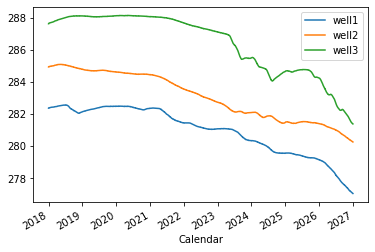

In [22]:
# tell Jupyter to show all graphics in-line:
%matplotlib inline

# create a basic plot of a time series
df_pivot.well1.plot()
df_pivot.well2.plot()
df_pivot.well3.plot()


import matplotlib.pyplot as plt
plt.legend()  # add a legend to the plot

In [23]:
# export the dataframe to an excel sheet
df_pivot.to_excel("./example_data/df_pivot.xlsx")

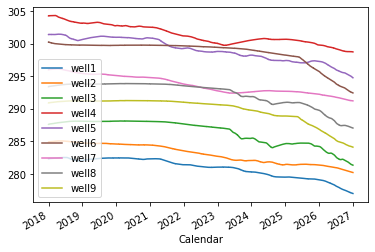

In [24]:
# method chaining - read excel sheet, set index and plot in one go
pd.read_excel("./example_data/df_pivot.xlsx").set_index("Calendar").plot()

***

## 2. Geopandas

Geopandas adds a spatial relation to a DataFrame, which then becomes a GeoDataFrame.
In addition to the index-column, a GeoDataFrame has a geometry column that contains a geometry (points, line, polygon). Note that GeoPandas is 2D. 

###   Accessing shp-files

If you know how a shape file looks like from the inside, you know what a GeoDataFrame is:

In [25]:
import geopandas as gpd
gdf_isolines = gpd.read_file("./example_data/isolines_final_head.shp")
gdf_isolines

,ISOLINE,F,geometry
0,2,479.0,"MULTILINESTRING ((520202.794 7499857.342, 5201..."
1,5,483.0,"LINESTRING (519057.884 7500724.131, 519101.872..."
2,7,477.0,"MULTILINESTRING ((520851.023 7499882.828, 5208..."
3,9,481.0,"MULTILINESTRING ((519976.098 7499799.998, 5199..."
4,13,482.0,"LINESTRING (519394.310 7499809.556, 519399.201..."
5,0,0.0,"LINESTRING (524200.903 7501772.448, 524188.771..."
6,0,0.0,"LINESTRING (524513.753 7499965.386, 524480.399..."


In [26]:
gdf_points = gpd.read_file("./example_data/points.shp")
gdf_points

,NODE,X,Y,FINIT,FINIT_U,geometry
0,23,522777.689,7501492.124,495.455196,m,POINT (522777.689 7501492.124)
1,35,521016.800,7500859.167,494.764415,m,POINT (521016.800 7500859.167)
2,36,521660.900,7499993.000,495.163527,m,POINT (522310.791 7500235.116)
3,50,520905.100,7500015.000,495.178737,m,POINT (520726.698 7500339.946)
4,61,520268.800,7499896.000,495.454282,m,POINT (520268.800 7499896.000)
5,67,521935.010,7501093.660,494.905555,m,POINT (521935.010 7501093.660)
6,70,522244.186,7501039.629,495.158911,m,POINT (522244.186 7501039.629)
7,81,523685.647,7500891.147,496.680806,m,POINT (523685.647 7500891.147)
8,86,521740.300,7500808.830,494.966934,m,POINT (521536.412 7501050.946)
9,99,521878.352,7500670.231,495.168131,m,POINT (521674.464 7500912.347)


this is not very pretty - the actual idea with a GeoDataFrame is to show it on a map: 

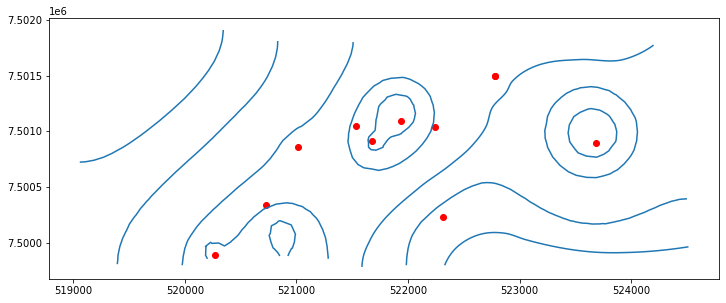

In [27]:
%matplotlib inline
ax1 = gdf_isolines.plot(figsize=(12,6))
gdf_points.plot(ax=ax1, color="red")

###  Spatial Selection

Where DataFrames allows slicing by value (`DataFrame.loc`) or index (`DataFrame.iloc`), a GeoDataFrame adds spatial slicing (`GeoDataFrame.cx`) to choose elements in a certain range of x- and y- coordinates.

For more complex spatial selections see http://geopandas.org/set_operations.html how to use overlays and set operations.

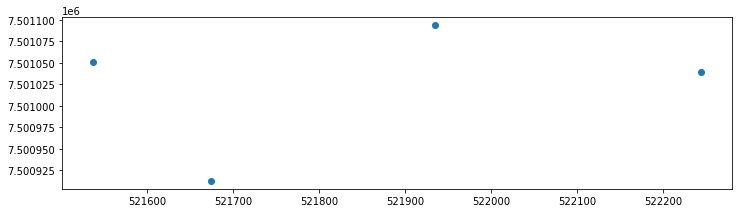

In [28]:
# select all elements with 521000 < x < 523000
gdf_points.cx[521500:522250,:].plot(figsize=(12, 6))